Liberaries imports

In [4]:
import quandl
import datetime
import cpi
from matplotlib import style

In [5]:
import os

In [6]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

## WARNING!

`cpi.update()` is a heavy function that updates the entire CPI package and is very bloaty and unnecessary! 

**Uncomment and run if absolutely needed!**

In [8]:
# cpi.update()

In [9]:
#import API key
from SECRET_KEY import quandel_key
quandel_key

'qrznzr7vcG1HMd7ae2E7'

In [10]:
style.use('ggplot')


# ************** START OF THE RESEARCH*********************

My Course of Action:

1) Create an index for companies that could project how lyft should function. 

2) Create a function to do the these steps to a single stock
    - Import first 261 days (1 fiscal year) of stock prices for each stock
    - keep the Open, High, Low, Close, Volume, Ex-Dividend for each stock in the dataframe
    - Adjust for inflation using easy money
    - create a column to isolate the month for seasionality
    - number each instance by # of day in the year
    - Save to a .csv in the /data directory
    
3) Create a function to Graph a given dataframe

4) Create a fucntion to merge the datasets together. 

5) Normalize the full DS

6) Instaniate a linuar regression model and train it with the overall data

7) Use what Lyft stock data we have to predict to test the first year of Lyft IPO

8) Make some sexy visuals from the prediction 

9) Analize the accuracy of the model

10) Create alternative indexes and repeat this process for all of them.  


In [11]:
#Write a function to combine multiple indexes
def super_index(index_a, index_b):
    super_index = index_a
    for i in index_b:
        super_index.append(i)
    return super_index
    

In [12]:
# combiend index
# cmb_index = super_index(tech_index, transportation_index)

In [13]:
#     my_data_dict = {"years": list(),
#                     "months": list()}
    
#     for item in df["Date"]:
#         my_data_dict["years"].append(item.year)
#         my_data_dict["months"].append(item.month)

In [14]:
# Create map of DJIA and import it into the stock column
djia=pd.read_csv('data/djia.csv')
djia.columns =['Date', "DJIA"]

In [15]:
djia.head()

,Date,DJIA
0,2016-04-15,17897.46
1,2016-04-14,17926.43
2,2016-04-13,17908.28
3,2016-04-12,17721.25
4,2016-04-11,17556.41


In [16]:
def import_process_stock(stock): #Stock is a stock code string
    """Uploads the data from Quandl and runs through the various 
        processes to get the data we want adjusted for inflation. 
        once data is processed it saves to a .csv and returns data in a dataframe
        if local .csv of stock data exists it returns that data as a dataframe"""

    if os.path.isfile("data/"+stock+".csv"):
        df= pd.read_csv("data/"+stock+".csv")
        return df
    
    df = quandl.get(("WIKI/"+stock), api_key=quandel_key)
#     - keep the Open, High, Low, Close, Volume, Ex-Dividend for each stock in the dataframe
    df = df[['Open','High','Low','Close','Volume','Ex-Dividend']]
    #Import first 261 days 
#     (1 fiscal year) of stock prices for each stock
    df = df.iloc[:261]   
    #Bring the timeserise index into the datafraem
    df=df.reset_index()
    #Add day and month numbers to time serise
    df['d_number'] = range(1, len(df)+1)
#   create a column to isolate the month for seasionality
    df['Year'], df['Month'] = 0,0
    my_data_dict = {"years": list(),
                    "months": list()}
    
    for item in df["Date"]:
        my_data_dict["years"].append(int(item.year))
        my_data_dict["months"].append(int(item.month))

    df["Year"] = my_data_dict["years"]
    df["Month"] = my_data_dict["months"]

    #improt DJIA data:
    df.Date = df.Date.dt.strftime('%Y-%m-%d')
    df = df.merge(djia, how='outer', on='Date')
    df = df.iloc[:261] 

    # Adjust for inflation using Consumer Price Index
    inflated_closing_vals = list()
    inflated_high_vals = list()
    inflated_low_vals= list()
    
    for index, year in enumerate(df["Year"].astype(int)):
        inflated_closing_vals.append(round(cpi.inflate(df["Close"].iloc[index], year, to=2018), 2))
        inflated_high_vals.append(round(cpi.inflate(df["High"].iloc[index], year, to=2018), 2))
        inflated_low_vals.append(round(cpi.inflate(df["Low"].iloc[index], year, to=2018), 2))
        
    df["inflated_close"] = inflated_closing_vals
    df["inflated_high"] = inflated_high_vals
    df["inflated_low"] = inflated_low_vals

    #convert stuff to int
    df["Year"] = df["Year"].astype(int)
    df["Month"] = df["Month"].astype(int)
    df["d_number"] = df["d_number"].astype(int)
    df["Volume"] = df["Volume"].astype(int)

    # rearange table
    df=df[["Date","d_number", "Month", "Year", "Volume", "DJIA", 
           "inflated_high", "inflated_low","inflated_close"]]
#     - Save to a .csv in the /data directory
    df.to_csv("data/"+stock+".csv")


    return df

In [17]:
def process_stock_list(stock_list):
    """This function takes a list of stocks, runs the process function on them and 
        returns one large datafraame of concantonated data from all stocks"""
    #instantiate datframe
    df1 = import_process_stock(stock_list[0])
    #run a loop on all other dataframes processing and combineing them to the originonal datafame. 
    for index in range(1,len(stock_list)-1):
        new_df = import_process_stock(stock_list[index])
        df1 = pd.concat([df1, new_df])
        
    return df1
         

In [18]:
def graph_df(df, stock):
    """"Graphs the closeing prie of a DF"""
    plt.plot(df["d_number"],df["inflated_close"], color ='g')
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('One Year since IPO stock prices for: {}'.format(stock))
    plt.show()
    
    ##WHY THE FUCK IS IT PLOTING THE D_NUMBER INSTED OF DATE? WHAT THE FLYING FUCK!!

In [19]:
def open_stock_csv(stock):
    """Opens the lyft csv downlaoded from Yahoo stocks"""
    df= pd.read_csv("data/"+stock+".csv")
    # Make it look like the rest of the stocks
#     df=df.reset_index()
    #Add day and month numbers to time serise
    df['d_number'] = range(1, len(df)+1)
#   create a column to isolate the month for seasionality

    df['Year'], df['Month'] = 0,0
    my_data_dict = {"years": list(),
                    "months": list()}
    
    for item in df["Date"]:
        d_list= item.split("-")
        my_data_dict["years"].append(d_list[0])
        my_data_dict["months"].append(d_list[1])

    df["Year"] = my_data_dict["years"]
    df["Month"] = my_data_dict["months"]
    

    df["inflated_high"]= df["High"]
    df["inflated_low"]= df["Low"]
    df["inflated_close"]=df["Close"]
    #make it like the same
    df=df[["Date","d_number", "DJIA", "Volume", "Year", "Month", "inflated_close"]]
    
    
    return df

In [20]:
def svr_stock_predictor(features, df, train_size=0.75):
    """ Runs a Support Vector Machine for Regression on a stock/index. """
    
    # Train the data
    X, y = df[features], df["inflated_close"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=1 - train_size)
    
    # Fit the data
    hyper = {
        "kernel": "linear",
        "degree": 3,
        "C": 1.0,
        "gamma": 0.001
    }
    model_SVR = SVR(kernel=hyper["kernel"])
    model_SVR.fit(X_train, y_train)
    
    y_pred = model_SVR.predict(X_test)
    accuracy = model_SVR.score(X_test, y_test)
    
    ret_params = {
        "y_pred": y_pred,
        "accuracy": accuracy,
    }
    
    return ret_params, model_SVR

In [21]:
def linear_stock_predictor(features,  df, train_size=0.75):
    """Runs a linear regression on a stock or index"""
    
    #Train the data
    X, y = df[features], df["inflated_close"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=1-train_size)
    
    #fit the data
    model_LinReg = LinearRegression()
    model_LinReg.fit(X_train, y_train)
    
    y_pred = model_LinReg.predict(X_test)
    weights, intercept = model_LinReg.coef_, model_LinReg.intercept_
    RSq, MSE = r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)
    
    ret_params = {
        "y_pred": y_pred,
        "weights": weights,
        "intercept": intercept,
        "RSq": RSq,
        "MSE": MSE
    }
    
    return ret_params, model_LinReg, y_test

# ****WORK SECTION****

Run LR_model on all tech stocks and than the index to see which is most accurate

In [22]:
# 1) create an index for tech stocks that might behave like Lyft
tech_index = ['TWTR', 'GOOGL', 'FB', 'AMZN', 'SPLK', 'PYPL', 'YHOO']

#Create an index for transportation companies:
# Picked three top and bottom preforming stocks from DJTransportation index:
#  https://www.marketwatch.com/investing/index/djt

transportation_index= ['MATX', 'LUV', 'JBLU', 'CAR', 'FDX', 'ALK']

In [23]:
wtf = import_process_stock('AMZN')

In [24]:
wtf.head()

,Unnamed: 0,Date,d_number,Month,Year,Volume,DJIA,inflated_high,inflated_low,inflated_close
0,0,1997-05-16,1,5,1997,1225000,7194.67,37.16,32.07,32.46
1,1,1997-05-19,2,5,1997,508900,7228.87,33.25,30.51,32.07
2,2,1997-05-20,3,5,1997,455600,7303.46,32.86,30.71,30.71
3,3,1997-05-21,4,5,1997,1571100,7290.68,30.90,25.81,26.80
4,4,1997-05-22,5,5,1997,981400,7258.13,27.19,24.64,26.21


In [25]:
one_feature = ["DJIA"]
all_features = ["DJIA", "Volume", "Year", "Month"]


tester = import_process_stock(tech_index[1])

test_ret = linear_stock_predictor(one_feature,tester )

In [26]:
# twtr_df=import_process_stock(tech_index[0])

# svr_stock_predictor(all_features, twtr_df, train_size=0.75)

In [ ]:
# svr_stock_predictor(features, df, train_size=0.75)
#     return ret_params, model_LinReg, y_test

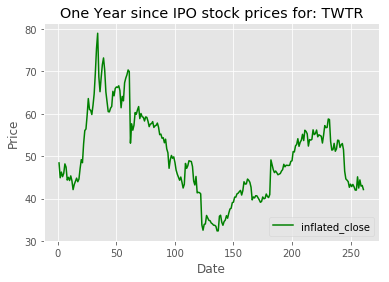

9.186%


In [84]:
#Twitter model alone

twtr_df=import_process_stock(tech_index[0])

graph_df(twtr_df,tech_index[0] )

avg_RSq = 0
for iteration in range(250):
    twtr_params, twtr_model, y_true =linear_stock_predictor(all_features,  twtr_df, train_size=0.75)
    avg_RSq += twtr_params['RSq']
print("{:.3f}%".format(100 * (avg_RSq / 250)))

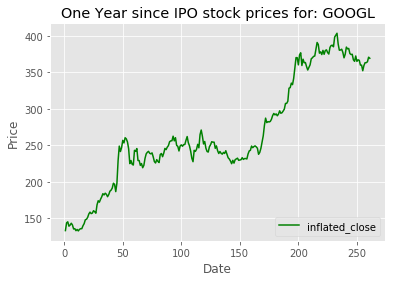

90.342%


In [85]:
#Google Model Alone

googl_df=import_process_stock(tech_index[1])

graph_df(googl_df, tech_index[1])

avg_RSq = 0
for iteration in range(250):
    googl_params, googl_model, y_true =linear_stock_predictor(all_features,  googl_df, train_size=0.75)
    avg_RSq += googl_params['RSq']
print("{:.3f}%".format(100 * (avg_RSq / 250)))

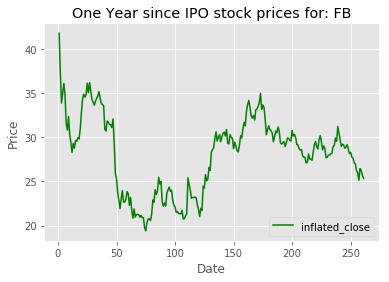

31.316%


In [86]:
#Facebook model alone

fb_df=import_process_stock(tech_index[2])

graph_df(fb_df, tech_index[2])

avg_RSq = 0
for iteration in range(250):
    fb_params, fb_model, y_true =linear_stock_predictor(all_features,  fb_df, train_size=0.75)
    avg_RSq += fb_params['RSq']
print("{:.3f}%".format(100 * (avg_RSq / 250)))

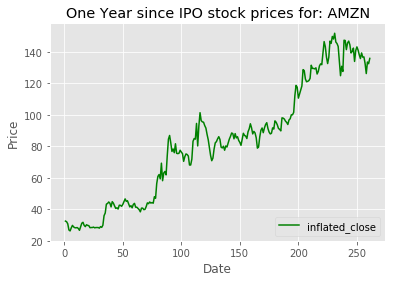

94.116%


In [87]:
#Amazon Model Alone

amzn_df=import_process_stock(tech_index[3])

graph_df(amzn_df, tech_index[3])

avg_RSq = 0
for iteration in range(250):
    amzn_params, amzn_model, y_true =linear_stock_predictor(all_features,  amzn_df, train_size=0.75)
    avg_RSq += amzn_params['RSq']
print("{:.3f}%".format(100 * (avg_RSq / 250)))

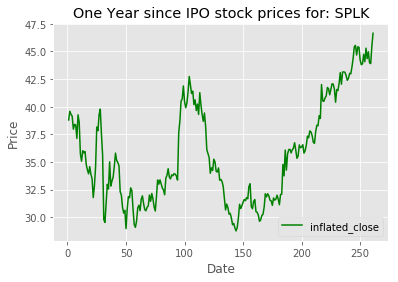

74.470%


In [88]:
#Splunk alone

splk_df=import_process_stock(tech_index[4])

graph_df(splk_df, tech_index[4] )

avg_RSq = 0
for iteration in range(250):
    splk_params, splk_model, y_true =linear_stock_predictor(all_features,  splk_df, train_size=0.75)
    avg_RSq += splk_params['RSq']
print("{:.3f}%".format(100 * (avg_RSq / 250)))

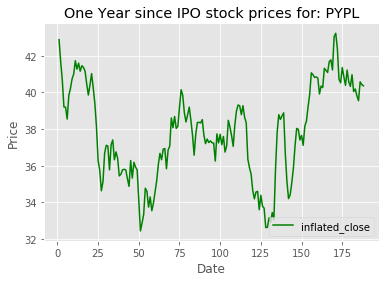

59.475%


In [89]:
#Paypal alone

pypl_df=import_process_stock(tech_index[5])

graph_df(pypl_df, tech_index[5])

avg_RSq = 0
for iteration in range(250):
    ppyl_params, ppyl_model, y_true =linear_stock_predictor(all_features,  pypl_df, train_size=0.75)
    avg_RSq += ppyl_params['RSq']
print("{:.3f}%".format(100 * (avg_RSq / 250)))

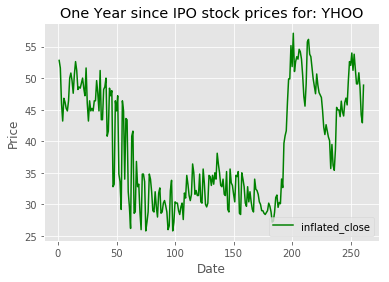

30.466%


In [90]:
#Yahoo alone

yhoo_df=import_process_stock(tech_index[6])

graph_df(yhoo_df, tech_index[6])

avg_RSq = 0
for iteration in range(250):
    yhoo_params, yhoo_model, y_true =linear_stock_predictor(all_features,  yhoo_df, train_size=0.75)
    avg_RSq += yhoo_params['RSq']
print("{:.3f}%".format(100 * (avg_RSq / 250)))

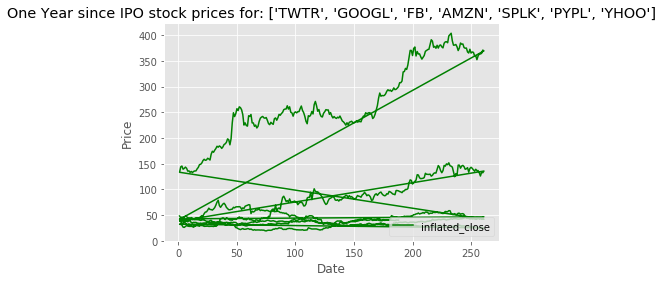

20.184%


In [34]:
#All target tech companies

tech_index_df= process_stock_list(tech_index)

graph_df(tech_index_df, tech_index)

avg_RSq = 0
for iteration in range(250):
    tech_params, tech_model, y_true =linear_stock_predictor(all_features,  tech_index_df, train_size=0.75)
    avg_RSq += tech_params['RSq']
print("{:.3f}%".format(100 * (avg_RSq / 250)))

In [35]:
# create an idex of most accurate tech stocks in this case: Google, Amazon, Paypal, and Splunk

consistant_tech_index= [tech_index[1], tech_index[3],tech_index[4],tech_index[5]]

In [36]:
# consistant tech stock index

const_tech_index_df= process_stock_list(tech_index)

avg_RSq = 0
for iteration in range(250):
    const_tech_params, const_tech_model, y_true =linear_stock_predictor(all_features,  const_tech_index_df, train_size=0.75)
    avg_RSq += const_tech_params['RSq']
print("{:.3f}%".format(100 * (avg_RSq / 250)))

20.635%


# Bring on the Lyft!

In [27]:
lyft_df= open_stock_csv('LYFT')
lyft_df.tail()

,Date,d_number,DJIA,Volume,Year,Month,inflated_close
269,2020-05-06,270,23913.142948,9516790,2020,05,NaN
270,2020-05-07,271,24135.585122,9516790,2020,05,NaN
271,2020-05-08,272,24387.650480,9516790,2020,05,NaN
272,2020-05-11,273,24412.336342,9516790,2020,05,NaN
273,2020-05-12,274,24372.819737,9516790,2020,05,NaN


In [28]:
def limited_data_predictor(features, df, data_entries=19):
    X, y = df[features], df["inflated_close"]
    
    X_train = X[:(data_entries+1)] # Feature data from Rows 1-19
    X_test = X[(data_entries+1):] # Feature data from Row 20->
    y_train = y[:(data_entries+1)] # Close data from Rows 1-19
#     y_test # DOES NOT EXIST
    
    #fit the data
    model_LinReg = LinearRegression()
    model_LinReg.fit(X_train, y_train)

    y_pred = model_LinReg.predict(X_test)
    weights, intercept = model_LinReg.coef_, model_LinReg.intercept_
#     RSq, MSE = r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)

    # add projections to the dataframe
    y_pred = np.insert(y_pred, 0, np.zeros(data_entries+1))
    df["forecast"] = y_pred

    ret_params = {
        "y_pred": y_pred,
        "weights": weights,
        "intercept": intercept
#         "RSq": RSq,
#         "MSE": MSE
    }
    
    #replace 0.0 with none for graphing 
    df['forecast'].replace(to_replace=0.0, value="")

    return df

For the Lyft data, I needed to project volume and the Down Jones Industreal Average. Here are my methods:
    
    Volume: I took the average volume for the existing data and used that as a constant.
    
    Dow Jones Industreal Average I took last yers data and projected it by a 3% projected US growth rate based on 
            Projectsion by the Federal Open Market Comission. After realizeing that this was a mistake. I creaed 
            a growth map from last years DJIA data and applied it to what we have. 
        

        https://www.thebalance.com/us-economic-outlook-3305669

In [29]:
lyft_projection= limited_data_predictor(all_features, lyft_df)

In [30]:
lyft_projection.head()

,Date,d_number,DJIA,Volume,Year,Month,inflated_close,forecast
0,2019-04-15,1,26384.77,14345900,2019,04,56.110001,0.0
1,2019-04-16,2,26452.66,9965000,2019,04,56.250000,0.0
2,2019-04-17,3,26449.54,10768300,2019,04,59.509998,0.0
3,2019-04-18,4,26559.54,6869900,2019,04,58.360001,0.0
4,2019-04-22,5,26511.05,5265600,2019,04,60.939999,0.0


In [31]:
len(lyft_projection)

274

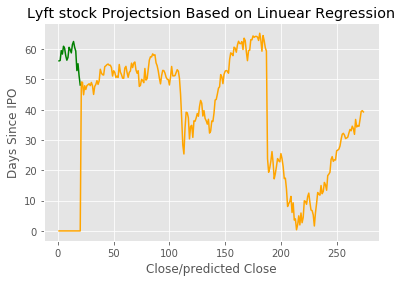

In [32]:
plt.plot(lyft_projection["d_number"],lyft_projection["inflated_close"], color='g' )
plt.plot(lyft_projection["d_number"],lyft_projection["forecast"], color='Orange' )

plt.xlabel('Close/predicted Close')
plt.ylabel('Days Since IPO')
plt.title('Lyft stock Projectsion Based on Linuear Regression')
plt.show()

# What happens when we use the index to predict lyft stocks?


In [37]:
index_params, index_model, index_y_test =linear_stock_predictor(all_features, tech_index_df )

In [38]:
index_params['RSq']

0.1812032422170291

In [57]:
all_features

['DJIA', 'Volume', 'Year', 'Month']

In [68]:
lyft_df2 = open_stock_csv('LYFT')
lyft_df2.head()

lyft_close = lyft_df2['inflated_close']
day_number = lyft_df2['d_number']

lyft_df2 = lyft_df2.drop(columns=['inflated_close'])
lyft_df2=lyft_df2[['DJIA', 'Volume', 'Year','Month']]

lyft_df2["Fen_forecast"] = index_model.predict(lyft_df2)

In [69]:
lyft_df2.head() 

,DJIA,Volume,Year,Month,Fen_forecast
0,26384.77,14345900,2019,04,-41.474096
1,26452.66,9965000,2019,04,-43.008818
2,26449.54,10768300,2019,04,-42.793777
3,26559.54,6869900,2019,04,-44.512278
4,26511.05,5265600,2019,04,-44.552409


In [70]:
lyft_df2["Actual Close"] = lyft_close
lyft_df2["d_number"] = day_number

In [71]:
lyft_df2.head()

,DJIA,Volume,Year,Month,Fen_forecast,Actual Close,d_number
0,26384.77,14345900,2019,04,-41.474096,56.110001,1
1,26452.66,9965000,2019,04,-43.008818,56.250000,2
2,26449.54,10768300,2019,04,-42.793777,59.509998,3
3,26559.54,6869900,2019,04,-44.512278,58.360001,4
4,26511.05,5265600,2019,04,-44.552409,60.939999,5


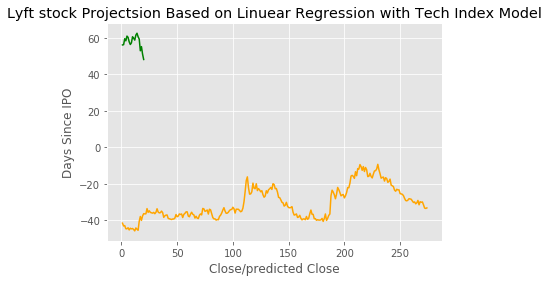

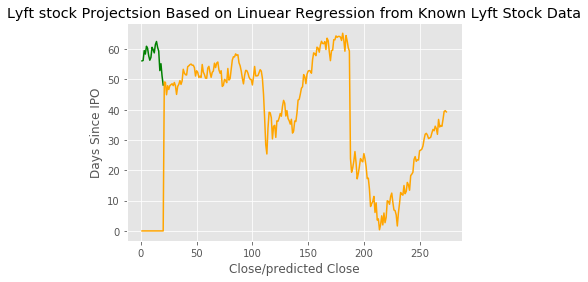

In [75]:
plt.plot(lyft_df2["d_number"],lyft_df2["Actual Close"], color='g' )
plt.plot(lyft_df2["d_number"],lyft_df2["Fen_forecast"], color='Orange' )

plt.xlabel('Close/predicted Close')
plt.ylabel('Days Since IPO')
plt.title('Lyft stock Projectsion Based on Linuear Regression with Tech Index Model')
plt.show()


plt.plot(lyft_projection["d_number"],lyft_projection["inflated_close"], color='g' )
plt.plot(lyft_projection["d_number"],lyft_projection["forecast"], color='Orange' )

plt.xlabel('Close/predicted Close')
plt.ylabel('Days Since IPO')
plt.title('Lyft stock Projectsion Based on Linuear Regression from Known Lyft Stock Data')
plt.show()

# Conclusions:
    
    1) Proxy data for stock prediction does not work.
    
    2) SVR Models do not like me(yes I take it personaly).
    
    3) Some stocks are more predictable than others.
    
    4) Predicting Stocks with Machine Learning is complex with many variables. 
    

# Next Steps: 
    
    1) Create a model to predict DJIA
    
    2) Push model to production environment with Flask app so that the model can update it'self in realtime.
    
    3) These types of predictions will invovle a lot more data. 